In [1]:
import joblib

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from config import fine_tuning
from libs.data import load_dataset, collate_fn, Dataset
from architecture.architecture import MaskedBlockAutoencoder
from architecture.shared_module import patchify, unpatchify

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
is_test_mode = False
is_new_rawdata = False
is_new_dataset = True
config = fine_tuning
device = torch.device("cuda")
# device = torch.device("cpu")

if is_new_dataset:
    train_dataset = load_dataset(is_test_mode, is_new_rawdata, config, mode="fine_tuning", verbose=True)
else:
    suffix = "_test" if is_test_mode else ""
    train_dataset = torch.load(f"src/fine_tuning_dataset{suffix}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config), pin_memory=True, num_workers=16, prefetch_factor=32)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config))
for _ in train_dataloader:
    [print(key, val.shape) for key, val in _.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:01<00:00, 19726.22it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([16, 280, 1])
day torch.Size([16, 280])
dow torch.Size([16, 280])
month torch.Size([16, 280])
holiday torch.Size([16, 280])
price torch.Size([16, 280, 1])
temporal_padding_mask torch.Size([16, 280])
target_fcst_mask torch.Size([16, 280])
img_path torch.Size([16, 3, 224, 224])
detail_desc torch.Size([16, 73])
detail_desc_revert_padding_mask torch.Size([16, 74])
detail_desc_remain_idx torch.Size([16, 73])
detail_desc_masked_idx torch.Size([16, 0])
detail_desc_revert_idx torch.Size([16, 73])


In [3]:
path = "saved_model_epoch9_2024-05-24 19:04:47.683949"
label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")

model = MaskedBlockAutoencoder(config, label_encoder_dict)
# mbae_model.load_state_dict(torch.load(path))
model.to(device)
summary(model, _, device, "fine_tuning", show_parent_layers=True, print_summary=True)
""

------------------------------------------------------------------------------------------------
            Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
   MaskedBlockAutoencoder      MBAEEncoder-1                         337,378,560      26,262,912
   MaskedBlockAutoencoder      MBAEDecoder-2                         176,554,047      20,996,223
Total params: 513,932,607
Trainable params: 47,259,135
Non-trainable params: 466,673,472
------------------------------------------------------------------------------------------------


''

In [4]:
for name, param in model.named_parameters():
#     # if "img_model" in name:
#     #     param.requires_grad = False
#     # elif "nlp_model" in name:
#     #     param.requires_grad = False
    
    # if "mbae_encoder" in name:
    #     param.requires_grad = False

    if "total_decoding" in name:
        if "sales" not in name:
            param.requires_grad = False
    if "decoder.output.output" in name:
        if "sales" not in name:
            param.requires_grad = False

In [5]:
import os
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from transformers import AutoTokenizer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_loss(pred_dict, y_dict, idx_dict, padding_mask_dict):
    loss_dict = {}
    loss_sum, cnt = 0, 0

    # Compute loss
    ### Temporal loss
    loss = mse_loss(pred_dict["sales"], y_dict["sales"].to(device)).squeeze()
    mask = torch.where((padding_mask_dict["temporal_padding_mask"]==1) & (padding_mask_dict["target_fcst_mask"]==0), 1, 0)
    loss *= mask
    loss = loss.sum() / mask.sum()

    loss_dict["sales"] = loss
    loss_sum += loss; cnt += 1
    
    total_loss = loss_sum / cnt
    return loss_dict, total_loss

def obtain_loss_dict_for_plot(total_loss, loss_dict, loss_li_dict, mean_loss_li_dict):
    loss_li_dict["total"].append(total_loss.item())
    mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())

    for key, val in loss_dict.items():
        loss_li_dict[key].append(val.item())
        mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())

    return loss_li_dict, mean_loss_li_dict

def plot_sample(nrows, ncols, config, mean_loss_li_dict, output_dict, data_dict, decoding_weight_dict):
    idx, plot_idx = 0, 1
    for key, val in mean_loss_li_dict.items():
        # Individual loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(val)
        plt.title(f"{key}: {val[-1]}")
        plot_idx += 1; 
        if key=="total": 
            plot_idx += 3; continue

        pred, y = output_dict[key].detach().cpu().squeeze(), data_dict[key].squeeze()
        length_dict = {"temporal" if key in config.temporal_cols else key :val.shape[1] for key, val in decoding_weight_dict.items()}
        length_dict["img_path"] = 197
        
        # Temporal sample
        if key in config.temporal_cols:
            ### Sample
            if key in config.embedding_cols: pred = torch.argmax(pred, dim=-1)
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(y[idx]); plt.plot(pred[idx])
            ### Weight
            decoder_weight = decoding_weight_dict[key][idx].mean(dim=0).detach().cpu()
            # decoder_weight = decoding_weight_dict[key][idx].min(dim=0).values.detach().cpu()
            ###### Temporal
            img_decoder_weight = decoder_weight[length_dict["temporal"]:length_dict["temporal"]+length_dict["img_path"]]
            img_decoder_weight = img_decoder_weight[1:]
            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(img_decoder_weight.reshape(224//config.patch_size, 224//config.patch_size))
            ###### Nlp
            os.environ["TOKENIZERS_PARALLELISM"] = "false"
            nlp_decoder_weight1 = decoder_weight[length_dict["temporal"]+length_dict["img_path"]:length_dict["temporal"]+length_dict["img_path"]+length_dict["detail_desc"]]
            nlp_decoder_weight2 = decoder_weight[length_dict["temporal"]+length_dict["img_path"]+length_dict["detail_desc"]:]
            nlp_decoder_weight = torch.cat([nlp_decoder_weight1[1:], nlp_decoder_weight2[1:]], dim=-1)

            nlp1 = tokenizer.tokenize(tokenizer.decode(data_dict["detail_desc"][idx]))
            # nlp2 = tokenizer.tokenize(tokenizer.decode(data_dict["information"][idx]))
            nlp2 = []
            text = nlp1 + nlp2

            df = pd.DataFrame({"text":text, "weight":nlp_decoder_weight})
            df = df[df["text"]!="[PAD]"]
            plt.subplot(nrows, ncols, plot_idx+2)
            sns.barplot(df["weight"])
            plt.gca().set_xticklabels(df["text"], rotation=90)

        # Img sample
        elif key in config.img_cols:
            pred = unpatchify(pred[:, 1:, :]).permute(0,2,3,1)
            y = y.permute(0,2,3,1)
            
            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(data_dict["img_path_raw"][idx].permute(1,2,0))

            plt.subplot(nrows, ncols, plot_idx+1)
            plt.imshow(y[idx])

            plt.subplot(nrows, ncols, plot_idx+2)
            plt.imshow(pred[idx])

        # Nlp sample
        elif key in config.nlp_cols:
            pred = tokenizer.decode(torch.argmax(pred, dim=-1)[idx])
            y = tokenizer.decode(y[idx])
        
        plot_idx += 3

    plt.tight_layout()
    plt.show()

def train_epoch(model, optimizer, dataloader, config, e):
    pbar = tqdm(dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    model.train()

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        decoding_output_dict, encoding_weight_dict, decoding_weight_dict, idx_dict, padding_mask_dict = model(data, device, "fine_tuning")
        loss_dict, loss = get_loss(decoding_output_dict, data, idx_dict, padding_mask_dict)
        loss.backward()
        optimizer.step()

        # Plot
        if n % 20 == 0:
            nrows, ncols = 12, 4
            plt.figure(figsize=(25,25))
            clear_output(wait=True)

            loss_li_dict, mean_loss_li_dict = obtain_loss_dict_for_plot(loss, loss_dict, loss_li_dict, mean_loss_li_dict)
            plot_sample(nrows, ncols, config, mean_loss_li_dict, decoding_output_dict, data, decoding_weight_dict)

1==1

True

/tmp/ipykernel_14949/2030475979.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df["text"], rotation=90)


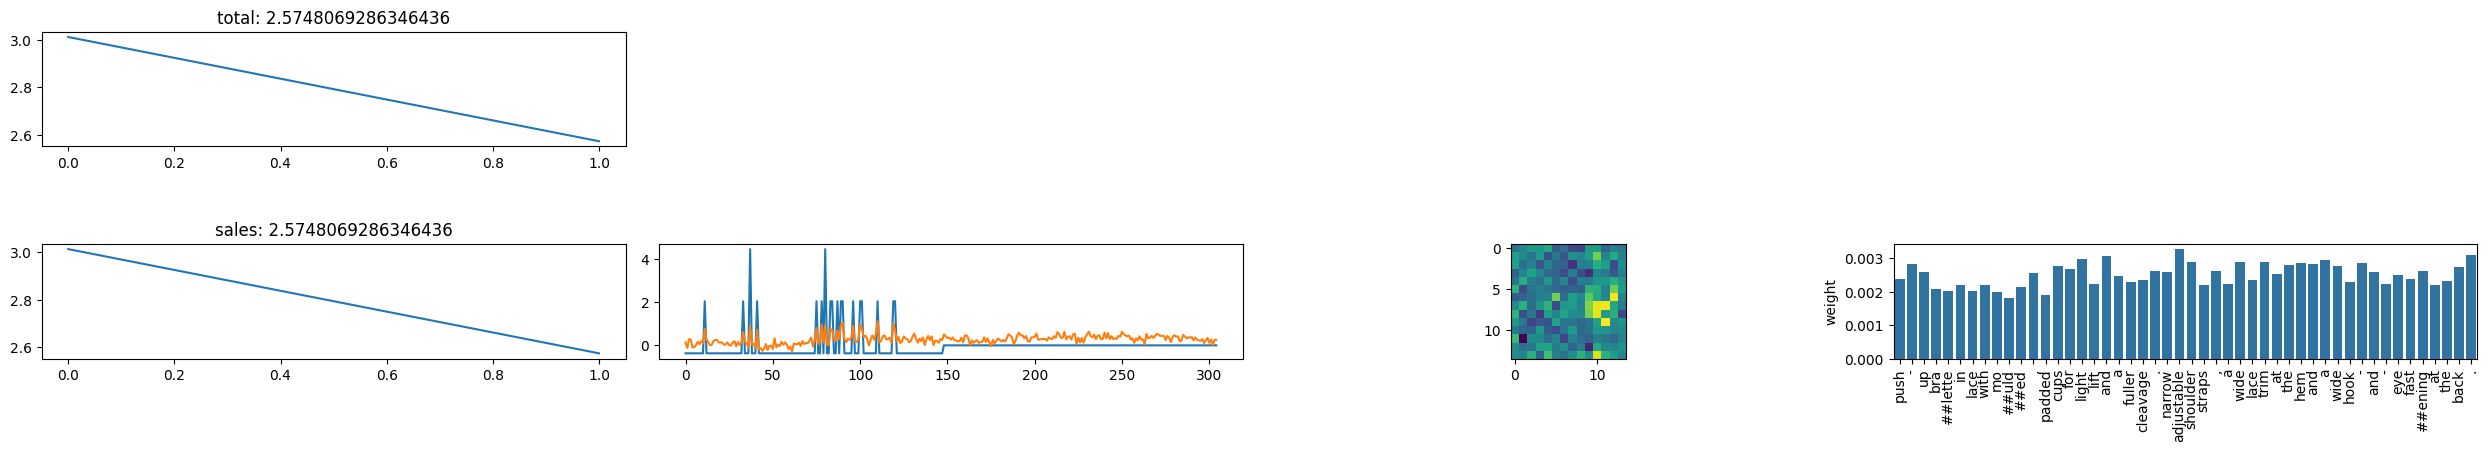

  1%|          | 21/1830 [00:12<17:48,  1.69it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 146.00 MiB (GPU 0; 23.67 GiB total capacity; 22.71 GiB already allocated; 137.25 MiB free; 23.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
epoch = 10

epoch_loss = {}
for e in range(epoch):
    loss = train_epoch(model, optimizer, train_dataloader, config, e)
    scheduler.step()
    epoch_loss[e] = loss

    # Save model
    if not is_test_mode:
        now = datetime.datetime.now()
        path = f"./saved_model_epoch{e}_{now}"
        torch.save(model.state_dict(), path)

print(epoch_loss)